# Исследование базы данных сервиса Stackoverflow

<b>Цель:</b>исследование, связанное с базой данных сервиса StackOverflow.<br>
<b>Описание:</b>В этом исследовании работа идёт с базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам. Я исследовал предоставленные данные, сформировал требуемые выгрузки данных с помощью SQL, посчитал различные продуктовые метрики и визуализировал их.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': '***', # имя пользователя
    'pwd': '***', # пароль
    'host': '***',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
select distinct Date_trunc('month', cast(creation_date as date)),
sum(views_count) over (partition by Date_trunc('month', cast(creation_date as date)))
from stackoverflow.posts
where extract(year from cast(creation_date as date)) = '2008'
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,date_trunc,sum
0,2008-07-01 00:00:00+04:00,669895
1,2008-08-01 00:00:00+04:00,131367083
2,2008-09-01 00:00:00+04:00,452928568
3,2008-10-01 00:00:00+04:00,365400138
4,2008-11-01 00:00:00+03:00,221759651
5,2008-12-01 00:00:00+03:00,197792841


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

<AxesSubplot:xlabel='date_trunc'>

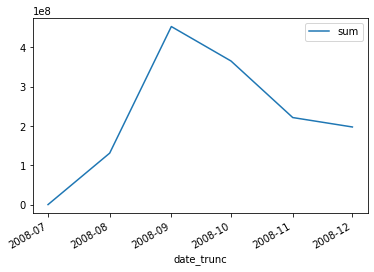

In [7]:
# напишите ваш ответ здесь
sample_df.plot(x='date_trunc')
#1. Данные отличаются. Видно что с окончанием лета идет рост просмотров и снижение к декабрю
#2. Снижения летом и ближе к декабрю могут быть связаны с периодами летних и зимних отпусков. 

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
with rr as (select  u.display_name as display_name,
p.user_id as us,
count(p.user_id) over (partition by u.id) as count
from stackoverflow.users u 
inner join stackoverflow.posts p on u.id = p.user_id
inner join stackoverflow.post_types pt on p.post_type_id = pt.id
where (pt.type = 'Answer') and (p.creation_date BETWEEN u.creation_date and u.creation_date + INTERVAL '1 month'))
select
distinct display_name,
count(distinct us)
from rr
where count > 100
group by 1
order by 1
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [9]:
# напишите ваш ответ здесь
print(sample_df['count'].sum())
query = '''
with rr as (
select
distinct id
from stackoverflow.users)
select 
distinct count(id) over () as count
from rr


'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

62


,count
0,24044


Если сравнить количество display_name с количеством уникальных user_id. То можно увидеть сильную разницу в значениях. Это может быть из-за повторяющихся имен c различными id.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос
query = '''
with rr as (
    select
        distinct u.id as us
        from stackoverflow.users u
        inner join stackoverflow.posts p on p.user_id = u.id
    where (cast(u.creation_date as date) between '2008-09-01' and '2008-09-30') and (cast(p.creation_date as date) between '2008-12-01' and '2008-12-31')
        
)
select date_trunc('month', cast(pt.creation_date as date)) as dt,
count(pt.id)
from stackoverflow.posts pt
inner join rr r on r.us = pt.user_id

where cast(pt.creation_date as date) between '2008-01-01' and '2008-12-31' 
group by 1
order by 1 desc
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,dt,count
0,2008-12-01 00:00:00+03:00,17641
1,2008-11-01 00:00:00+03:00,18294
2,2008-10-01 00:00:00+04:00,27171
3,2008-09-01 00:00:00+04:00,24870
4,2008-08-01 00:00:00+04:00,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

,count
count,5.000000
mean,17601.600000
std,10648.648614
min,32.000000
25%,17641.000000
50%,18294.000000
75%,24870.000000
max,27171.000000


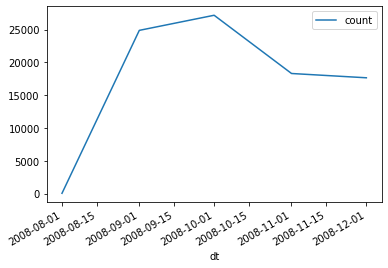

In [11]:
# напишите ваш ответ здесь
sample_df.sort_values(by='dt').plot(x='dt')
sample_df.describe()

1. Из полученных ранных видно что аномальные низкие значения находятся в августе. Это связано с тем что в августе пользователи еще не могли писать посты т.к. еще не зарегестрировались.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [12]:
# напишите запрос
query = '''
select
    user_id,
    creation_date,
    views_count as views_count,
    sum(views_count) over (partition by user_id order by creation_date)
    from stackoverflow.posts
    order by 1, 2
    
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [13]:
# напишите запрос
query = '''
with rr as (
select
distinct user_id as id,
count(id) over (partition by user_id) cnt_id
from stackoverflow.posts
where cast(creation_date as date) between '2008-08-01' and '2008-08-31'
),
rs as (
select 
r.id as usr_id,
date_trunc('day', cast(p.creation_date as date)) as dtt,
count(p.id) as cnt_day
from rr r
inner join stackoverflow.posts p on p.user_id = r.id
where cnt_id > 120 and cast(p.creation_date as date) between '2008-08-01' and '2008-08-31'
group by 1, 2
order by 1
 )
select 
s.usr_id,
avg(s.cnt_day)
from rs s
where s.cnt_day > 0
group by 1
order by 2
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,usr_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [14]:
# напишите запрос
query = '''
with rr as (
select 
p.user_id as usr_id,
date_trunc('day', cast(p.creation_date as date)) as dtt,
count(p.id) as cnt_day
from stackoverflow.posts p
where cast(p.creation_date as date) between '2008-12-01' and '2008-12-07'
group by 1, 2
order by 1
),
rs as (select
usr_id,
count(dtt) as result
from rr
where cnt_day > 0
group by 1)
select
round(avg(result))
from rs

'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,round
0,2.0


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

count    3766.000000
mean        1.772438
std         1.230206
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: result, dtype: float64

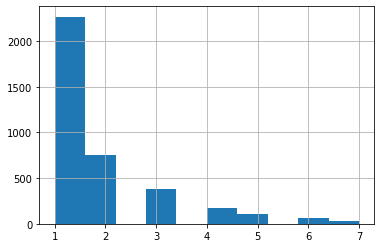

In [15]:
# напишите ваш ответ здесь
query = '''
with rr as (
select 
p.user_id as usr_id,
date_trunc('day', cast(p.creation_date as date)) as dtt,
count(p.id) as cnt_day
from stackoverflow.posts p
where cast(p.creation_date as date) between '2008-12-01' and '2008-12-07'
group by 1, 2
order by 1
)
select
usr_id,
count(dtt) as result
from rr
where cnt_day > 0
group by 1

'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df['result'].hist()
sample_df['result'].describe()
# Из полученных данных можно сделать вывод, что пользователи чаще всего взаимодействуют с сайтом в среднем два дня. 
#С увеличением дней взаимодействия, количество пользователей сильно снижается. Пользователи больше 7 дней не взаимодействуют

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [16]:
# напишите запрос
query = '''
with rr as (select 
user_id,
creation_date,
LAST_VALUE(extract(month from cast(creation_date as date))) over (partition by user_id order by creation_date) as last_value
from stackoverflow.posts)
select
user_id,
creation_date,
case
lag(last_value, 2, NULL) over(partition by user_id order by creation_date)
when 1 then 'January'
when 2 then 'February'
when 3 then 'March'
when 4 then 'April'
when 5 then 'May'
when 6 then 'June'
when 7 then 'July'
when 8 then 'August'
when 9 then 'September'
when 10 then 'October'
when 11 then 'November'
when 12 then 'December'
end as second_last_month
from rr
order by 1, 2
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [17]:
# напишите запрос
query = '''
with rr as(
select
distinct user_id,
first_value(date_trunc('month', cast(creation_date as date))) over(partition by user_id order by date_trunc('month', cast(creation_date as date))) as cohort_dt
from stackoverflow.posts
),
profile as (
select
distinct user_id,
cohort_dt,
count(user_id) over (partition by cohort_dt) as cohort_users_cnt
from rr),
sessions as (
select
user_id,
date_trunc('month', cast(creation_date as date)) as session_date
from stackoverflow.posts
group by 1, 2
)
select
p.cohort_dt,
s.session_date,
count(p.user_id) as users_cnt,
cohort_users_cnt,
round(count(p.user_id) * 100.0 / cohort_users_cnt, 2) as retention_rate
from profile p join sessions s on p.user_id = s.user_id
group by 1, 2, 4

 

'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01 00:00:00+04:00,2008-07-01 00:00:00+04:00,3,3,100.00
1,2008-07-01 00:00:00+04:00,2008-08-01 00:00:00+04:00,2,3,66.67
2,2008-07-01 00:00:00+04:00,2008-09-01 00:00:00+04:00,1,3,33.33
3,2008-07-01 00:00:00+04:00,2008-10-01 00:00:00+04:00,2,3,66.67
4,2008-07-01 00:00:00+04:00,2008-11-01 00:00:00+03:00,1,3,33.33
5,2008-07-01 00:00:00+04:00,2008-12-01 00:00:00+03:00,2,3,66.67
6,2008-08-01 00:00:00+04:00,2008-08-01 00:00:00+04:00,2151,2151,100.00
7,2008-08-01 00:00:00+04:00,2008-09-01 00:00:00+04:00,1571,2151,73.04
8,2008-08-01 00:00:00+04:00,2008-10-01 00:00:00+04:00,1275,2151,59.27
9,2008-08-01 00:00:00+04:00,2008-11-01 00:00:00+03:00,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

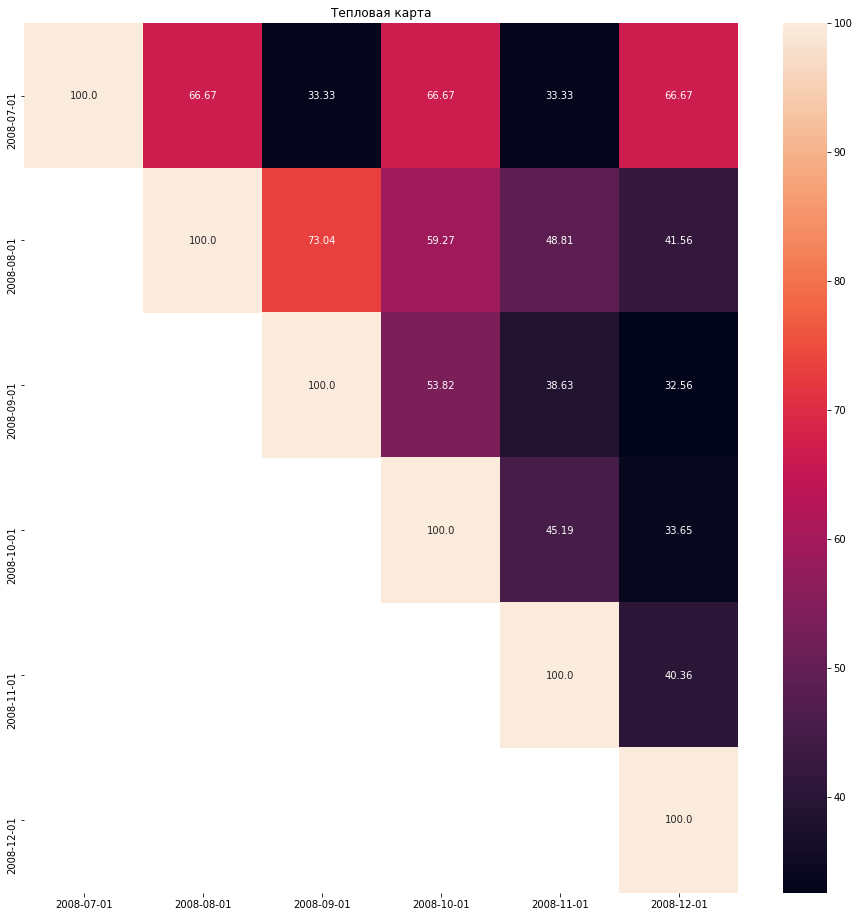

In [18]:
# постройте тепловую карту Retention Rate
import seaborn as sns
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

# опишите аномалии или другие необычные явления и сформулируйте гипотезы
видно аномалии в данных пользователей когорты за июль. В данных нет плавного снижения кол-ва пользователей. Так же видно что данные в этой когорте поочередно повторяются.
Данные проблемы могут возникнуть из-за сбоев в отслеживании данной когорты. Например неправильно сохранены их данные, возможно данные пострадали при копировании. Очень похоже на то что данные за два месяца продуюлировались на весь рассматриваемый период

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [19]:
# напишите запрос
query = '''
with rr as (select 
  distinct extract(month from cast(creation_date as date)) as creation_month,
  count(id) over (partition by extract(month from cast(creation_date as date))) as posts_count
  from stackoverflow.posts
  where cast(creation_date as date) between '2008-09-01' and '2008-12-31'),
  rs as (select
  creation_month,
  posts_count,
  lag(posts_count, 1, NULL) over(order by creation_month) as last_posts_count
  from rr)
  select
  creation_month,
  posts_count,
  round(((last_posts_count::numeric - posts_count) / last_posts_count::numeric) * 100, 2) * -1 as percentage
  from rs
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df
# выполните запрос

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

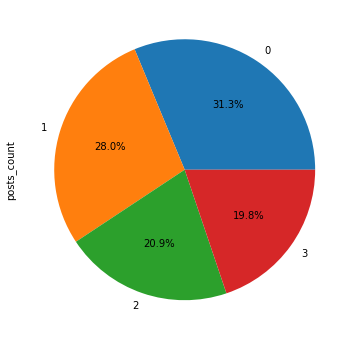

In [20]:
# постройте круговую диаграмму с количеством постов по месяцам
sample_df1 = sample_df[['creation_month','posts_count']]
sample_df1['posts_count'].plot(kind='pie', figsize=(6,6), y=['creation_month'], subplots=True, autopct='%1.1f%%')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [21]:
# напишите запрос
query = '''
with rr as (
    select
    user_id,
    count(id)
    from stackoverflow.posts
    group by 1
    order by 2 desc limit 1
)
select
    distinct extract(week from cast(p.creation_date as date)),
    max(p.creation_date)
    from stackoverflow.posts p
    inner join rr r on r.user_id = p.user_id
    where cast(creation_date as date) between '2008-10-01' and '2008-10-31'
    group by extract(week from cast(p.creation_date as date))
    order by 1, 2
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,date_part,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
